In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt


In [2]:

gray_house = cv2.imread("houses.jpg",0)
gray_sudoku = cv2.imread("sudoku.jpg",0)
house_type = gray_house.dtype
sudoku_type = gray_sudoku.dtype
block_size = [50,100,125]



In [3]:
def createBlank(img): 
    new_img = cv2.cvtColor(img,0)
    return new_img
    

In [4]:
def global_threshold(img,threshold,d_type,color): 
    #threshold gray
    threshold_img = np.zeros(img.shape,dtype = d_type)
    if color == 0: 
        for i in range(0, img.shape[0]):
            for j in range(0, img.shape[1]):
                if img[i,j] < threshold: 
                    threshold_img[i,j] = 0
                else: 
                    threshold_img[i,j] = 255
    #threshold red
    elif color == 1:
        for i in range(0, img.shape[0]):
            for j in range(0, img.shape[1]):
                if img[i,j][2] < threshold: 
                    threshold_img[i,j] = [0,0,0]
                else: 
                    threshold_img[i,j] = [0,0,255]
        
    #threshold green
    elif color == 2: 
        for i in range(0, img.shape[0]):
            for j in range(0, img.shape[1]):
                if img[i,j][1] < threshold: 
                    threshold_img[i,j] = [0,0,0]
                else: 
                    threshold_img[i,j] = [0,255,0]
                
    #threshold green
    else: 
        for i in range(0, img.shape[0]):
            for j in range(0, img.shape[1]):
                if img[i,j][0] < threshold: 
                    threshold_img[i,j] = [0,0,0]
                else: 
                    threshold_img[i,j] = [255,0,0]
        
    return threshold_img
            

Text(0.5, 1.0, 'House Simple Threshold')

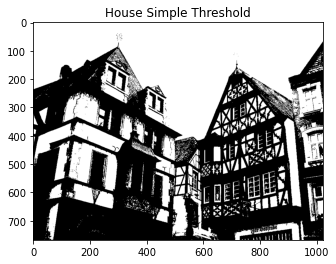

In [5]:
threshold_houses = cv2.cvtColor(global_threshold(gray_house,127,house_type,0),0)
plt.imshow(threshold_houses, cmap = 'gray')
plt.title("House Simple Threshold")

Text(0.5, 1.0, 'Sudoku Simple Threshold')

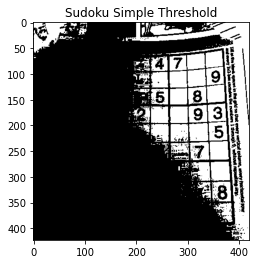

In [6]:
threshold_sudoku = cv2.cvtColor(global_threshold(gray_sudoku,127,sudoku_type,0),0)
plt.imshow(threshold_sudoku, cmap = 'gray')
plt.title("Sudoku Simple Threshold")

In [7]:
def auto_threshold(img): 
    temp_img = img.copy()
    
    def adjust_gray(threshold): 
        adjusted = cv2.cvtColor(global_threshold(temp_img,threshold,"uint8",0),0)
        cv2.imshow("Simple Threshold Adjustment", adjusted)

    def adjust_threshold_house():
        cv2.namedWindow("Simple Threshold Adjustment")
        cv2.createTrackbar("Threshold","Simple Threshold Adjustment", 0, 255, adjust_gray)
        cv2.setTrackbarPos("Threshold","Simple Threshold Adjustment",127)
        cv2.imshow("Simple Threshold Adjustment", temp_img)   
        cv2.waitKey(0)
        cv2.destroyAllWindows()    

    adjust_threshold_house()




In [8]:
auto_threshold(gray_house)

In [9]:
auto_threshold(gray_sudoku)

In [10]:
def tile_img(img,step_size): 
    tile_img = createBlank(img)  
    m = 0 
    while m < tile_img.shape[1]: 
        n = 0
        while n < tile_img.shape[0]: 
            tile_img = cv2.rectangle(tile_img,(m,n),(m+step_size,n+step_size),(200,0,0),1)
            
            threshold_img = [img[m:n, m + step_size: n + step_size]]
            n += step_size
        m += step_size
    
    return tile_img
            
   
    
    

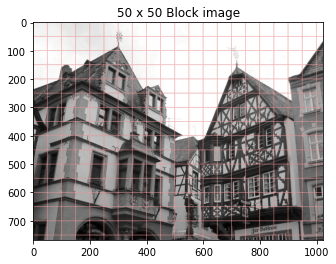

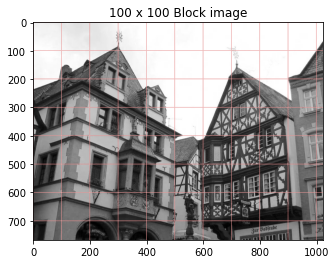

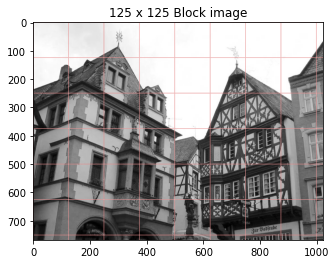

In [11]:
for size in block_size:
    plt.figure()
    plt.imshow(tile_img(gray_house,size), cmap = "gray")
    plt.title(str(size) + " x " + str(size) + " Block image")




In [12]:
def otsu_alg(img):
    
    histogram,b = np.histogram(img, np.arange(0,257))
    #between class variance vals
    max_varb = -1
    thresholdb = -1
    
    #within class variance vals
    min_varw = 999999
    thresholdw = -1
    norm = 1.0/(img.shape[0]*img.shape[1])
    t_vals = np.arange(256)
    historgram = histogram*norm
    
    
        
    for thresh in b[1:-1]:
        sum_histogram = np.sum(histogram) 
        if sum_histogram == 0: 
            sum_histogram == 1
        
        probability_b = np.sum(histogram[:thresh])
        probability_f = np.sum(histogram[thresh:])
        
        if probability_f == 0:
            probability_f = 1
           
        if probability_b == 0:
            probability_b = 1
        #weight background
        w_b = probability_b * (1.0/sum_histogram)
        
        #weight forground
        w_f = probability_f * (1.0/sum_histogram)
        
        #mean background
        m_b = np.sum(histogram[:thresh]*t_vals[:thresh])/(probability_b)
        #mean forground
        m_f = np.sum(histogram[thresh:]*t_vals[thresh:])/(probability_f)
        
        var_B = w_b*w_f*(m_b - m_f)**2
        
        if var_B > max_varb: 
            thresholdb = thresh
            max_varb = var_B
            
        var_b = np.sum([((i - m_b)**2) for i in range(thresh)]*histogram[:thresh])/probability_b
        var_f = np.sum([((i - m_f)**2) for i in range(thresh,256)]*histogram[thresh:])/probability_f
        

        var_w = (w_b*var_b) + (w_f*var_f)
        
        if var_w < min_varw: 
            thresholdw = thresh
            min_varw = var_w
        
    threshold_img = np.zeros(img.shape,dtype = "uint8")
    
    if thresholdb > 248: 
        thresholdb = thresholdb - 40
   
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if img[i,j] < thresholdb: 
                threshold_img[i,j] = 0
            else: 
                threshold_img[i,j] = 255
    
    return threshold_img
            
                    

In [13]:
def split_img(img,size): 
    split_arr = []
    n = size
    m = size 
    for i in range(0, img.shape[0], n): 
        for j in range(0, img.shape[1], m): 
            if i + n > img.shape[0] and j + n > img.shape[1]: 
                partial = img[i: i + (img.shape[0] - i), j: j + (img.shape[1] - j)]
                split_arr.append(partial)
                break
            elif i + n > img.shape[0] : 
                partial = img[i: i + (img.shape[0] - i), j: j + m]
                split_arr.append(partial)
                
            elif i + m > img.shape[1] : 
                partial = img[i: i + n, j: j + (img.shape[1] - j)]
                split_arr.append(partial)
                
            else:
                partial = img[i: i + n, j: j + m]
                split_arr.append(partial)
                
    return split_arr

In [14]:
def otsu_thresh(img, size):
    imgs = split_img(img,size)
    empty = np.zeros(img.shape,dtype = "uint8")
    for index in range(len(imgs)):
        imgs[index] = otsu_alg(imgs[index])
    
    count = 0
    for i in range(0, empty.shape[0], size): 
        for j in range(0, empty.shape[1], size): 
            if i + size > empty.shape[0] and j + size > empty.shape[1]: 
                empty[i: i + (empty.shape[0] - i), j: j + (empty.shape[1] - j)] = imgs[count]
                count += 1
                break
            elif i + size > empty.shape[0] : 
                empty[i: i + (empty.shape[0] - i), j: j + size] = imgs[count]
                count += 1
            elif i + size > empty.shape[1] : 
                empty[i: i + size, j: j + (empty.shape[1] - j)] = imgs[count]
                count += 1
            else:
                empty[i: i + size, j: j + size] = imgs[count]
                count +=1 
                
    return empty
    
   
    
    
    

Text(0.5, 1.0, 'House Simple Threshold')

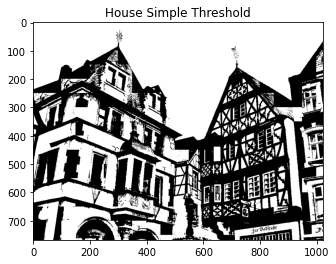

In [15]:
otsu_image = otsu_thresh(gray_house, 50)
plt.imshow(otsu_image, cmap = 'gray')
plt.title("House Simple Threshold")

Text(0.5, 1.0, 'House Simple Threshold')

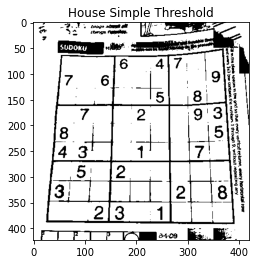

In [16]:
otsu_image = otsu_thresh(gray_sudoku, 50)
plt.imshow(otsu_image, cmap = 'gray')
plt.title("House Simple Threshold")

(1478, 1200)


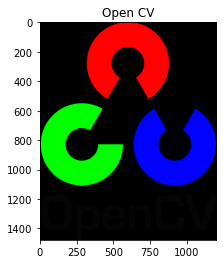

In [17]:
ovc = cv2.imread("OCVLogo.png")
plt.imshow(cv2.cvtColor(ovc,cv2.COLOR_BGR2RGB))
plt.title("Open CV")
shape = (ovc.shape[0],ovc.shape[1])
print(shape)

In [18]:
def seperateChannels(img,shape):
    red, green, blue = np.zeros(shape,np.uint8),np.zeros(shape,np.uint8),np.zeros(shape,np.uint8)
    
    row = shape[0]
    column = shape[1]
            
    for i in range(0,row):
        for j in range(0, column):
            pixel = img[i,j]
            red[i,j] = [0,0,pixel[2]]
            
            green[i,j] = [0,pixel[1],0]
            
            blue[i,j] = [pixel[0],0,0]
    
    red = cv2.cvtColor(global_threshold(red,127,"uint8",1),cv2.COLOR_BGR2RGB)
    green = cv2.cvtColor(global_threshold(green,127,"uint8",2),cv2.COLOR_BGR2RGB)
    blue = cv2.cvtColor(global_threshold(blue,127,"uint8",3),cv2.COLOR_BGR2RGB)
            
    return [red,green,blue]

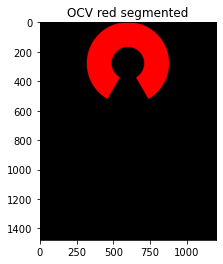

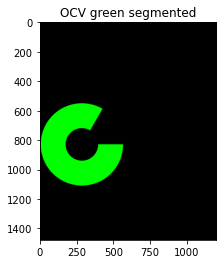

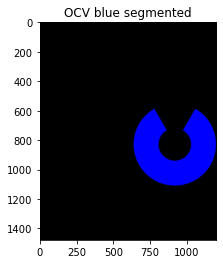

In [19]:
channels = seperateChannels(ovc,ovc.shape)
colors = {0 : "red", 1: "green", 2 : "blue"}
for i in range(len(channels)):
    plt.figure()
    plt.imshow(channels[i])
    plt.title("OCV " + colors[i] + " segmented")
    
